**Testing of importing and preprocessing of Sentinel-1 data with pyroSAR**

**COPY-PASTES OF TERMINAL COMMANDS:**  
TMUX:  
tmux new -s juho  
conda activate env312  
tmux list-sessions  
tmux attach-session -t juho  
To detach: ctrl+b -> d  
  
JUPYTER:  
jupyter notebook --no-browser --port=8888  
To close: ctrl+c -> y -> enter  
  
  
**IMPORTS**

In [1]:
import tempfile
import os
os.environ['PATH'] = '/home/st-juho/esa-snap/bin:' + os.environ['PATH']
import requests
import zipfile
from PIL import Image
import io

import rasterio
from rasterio.transform import array_bounds

import matplotlib.pyplot as plt
import numpy as np

import pyroSAR as ps
from pyroSAR import identify
from pyroSAR.snap import geocode

import psutil
from IPython.core.magic import register_cell_magic

import geopandas as gpd
from shapely.geometry import Polygon

In [2]:
#Memory setup
os.environ["JAVA_TOOL_OPTIONS"] = "-Xmx128G"  # <-- sets Java heap to 128 GB


FUNCTIONS

In [3]:
def normalize_safe_path(path: str) -> str:
    """
    Normalize Sentinel-1 SAFE product paths for pyroSAR.
    
    Handles these cases:
    - A .SAFE folder
    - A .SAFE.zip archive
    - A wrong combined path like "...SAFE.zip/...SAFE"
    
    Returns
    -------
    str
        Path suitable for pyroSAR (either the .SAFE folder or the .SAFE.zip file).
    """
    path = os.path.normpath(path)

    # Case 1: already pointing to a SAFE folder
    if path.endswith(".SAFE") and os.path.isdir(path):
        return path
    
    # Case 2: a SAFE.zip file
    if path.endswith(".SAFE.zip") and os.path.isfile(path):
        return path
    
    # Case 3: something like "...SAFE.zip/...SAFE"
    if ".SAFE.zip" in path and ".SAFE" in path:
        # strip off the trailing .SAFE
        safezip = path.split(".SAFE.zip")[0] + ".SAFE.zip"
        if os.path.isfile(safezip):
            return os.path.normpath(safezip)
    
    raise FileNotFoundError(f"Could not normalize SAFE path: {path}")

def read_and_mask(tif_path):
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        nodata = src.nodata
    arr = np.array(arr, copy=True)
    # Always convert to masked array so .filled() works
    if nodata is not None:
        arr = np.ma.masked_equal(arr, nodata)
    else:
        arr = np.ma.masked_array(arr)  # <-- this line ensures arr is always masked
    arr_finite = arr.filled(np.nan)
    vmin = np.nanpercentile(arr_finite, 2)
    vmax = np.nanpercentile(arr_finite, 98)
    return arr, vmin, vmax

START OF MAIN

Import Sentinel-1 data

In [4]:


print("Hello world!")

# Find a Sentinel-1 product zip file in the current script's directory
script_dir = os.getcwd()
product_zip = None
for fname in os.listdir(script_dir):
    if fname.endswith('.SAFE') and fname.startswith('S1'):
        product_zip = os.path.join(script_dir, fname)
        break

print(f"Product zip file: {product_zip}")

if product_zip is None:
    print("No Sentinel-1 product zip file found in the script directory.")
else:
    # Identify the product
    scene = identify(product_zip)

Hello world!
Product zip file: /home/st-juho/code_testing/S1A_IW_SLC__1SDV_houston_test_1.SAFE


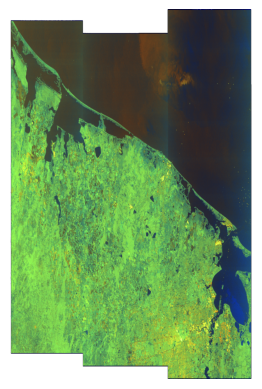

In [5]:
## SHOW QUICKLOOK ##

# Read a quicklook image if available
scene.quicklook('testing_quicklook.kmz')
# The quicklook image is stored inside the KMZ file as a PNG or JPG
with zipfile.ZipFile('testing_quicklook.kmz', 'r') as kmz:
    for name in kmz.namelist():
        if name.lower().endswith(('.png', '.jpg', '.jpeg')):
            with kmz.open(name) as img_file:
                img = Image.open(img_file)
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            break

PREPROCESSING

In [6]:
## Define file locations ##

# Define output directory for preprocessed data
out_dir = os.path.join(script_dir, 'preprocessed')
os.makedirs(out_dir, exist_ok=True)

# Run geocode (pyroSAR's main preprocessing function)
infile = normalize_safe_path(scene.file)

In [7]:
## Refine the location (Shapefile) ##
coords = [(-95.40, 29.65),
          (-95.40, 29.85),
          (-95.15, 29.85),
          (-95.15, 29.65),
          (-95.40, 29.65) ]

poly = Polygon(coords)

# Make GeoDataFrame
gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[poly])

# Save as shapefile
gdf.to_file("houston_boundary.geojson", driver="GeoJSON")

In [8]:
#TODO: Add location with shapefile

geocode(
    infile=infile,
    outdir=out_dir,
    polarizations='all',
    scaling='dB',
    demName='Copernicus 30m Global DEM',
    shapefile='houston_boundary.geojson',
    refarea=['sigma0','gamma0'],  # Added reference area for gamma0 calibration
    #Note, external DEM is also possible with externalDEMfile=, look at documentation for more info.
    #basename_extensions=['preprocessed_test_1'], only works with select list of attributes, not any name.
    export_extra=['DEM', 'incidenceAngleFromEllipsoid', 'localIncidenceAngle', 'projectedLocalIncidenceAngle', 'layoverShadowMask', 'gammaSigmaRatio', 'scatteringArea'], #more examples: 'localIncidenceAngle', 'layoverShadowMask' 
    cleanup=True,
    nodataValueAtSea=True, #Gotta think about this one
    tmpdir=tempfile.gettempdir()
)

VISUALIZATION

In [9]:
#Select the input file, open it, and process for visualization

tif_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_VV_gamma0-rtc_db.tif"

# Open the file and read band and nodata inside the same block
with rasterio.open(tif_file) as src:
    vv = src.read(1)  # first band
    nodata = src.nodata  # store nodata value
    profile = src.profile

# Make a writable copy
vv = np.array(vv, copy=True)

# Mask nodata values if they exist
if nodata is not None:
    vv = np.ma.masked_equal(vv, nodata)

# Convert masked values to nan for percentile calculation
vv_finite = vv.filled(np.nan)

# Compute vmin and vmax safely
vmin = np.nanpercentile(vv_finite, 2)
vmax = np.nanpercentile(vv_finite, 98)

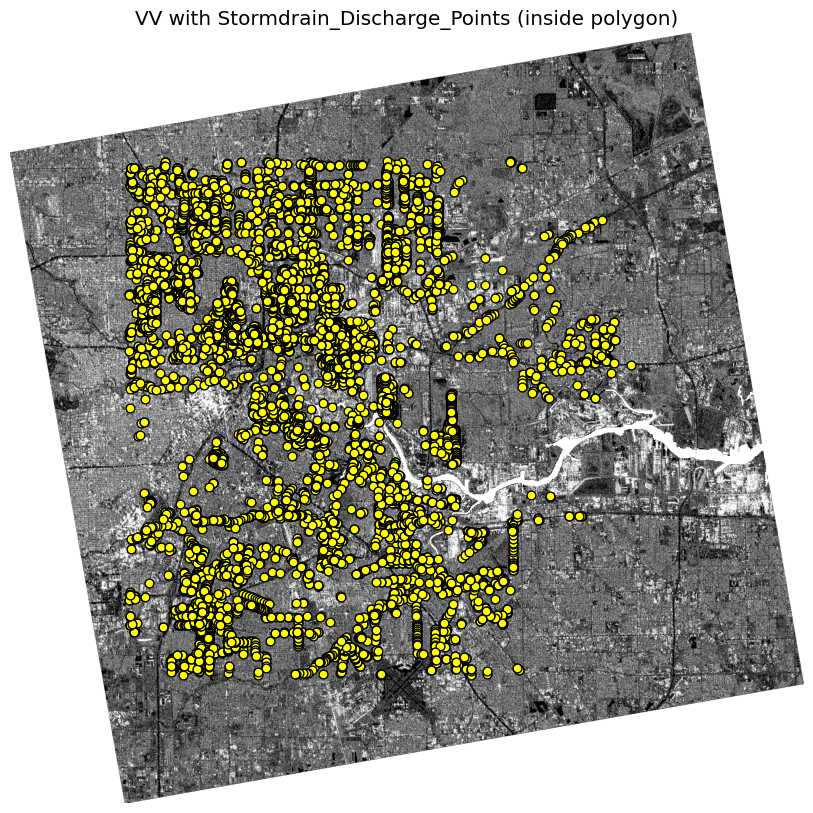

In [10]:


shp_root = "/home/st-juho/code_testing/houston_public_works_data"
shp_path = os.path.join(shp_root, "Stormdrain_Discharge_Points", "Stormdrain_Discharge_Points.shp")

# compute raster extent from profile
height = profile['height']
width = profile['width']
transform = profile['transform']
minx, miny, maxx, maxy = array_bounds(height, width, transform)
extent = (minx, maxx, miny, maxy)

fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(vv, cmap='gray', vmin=vmin, vmax=vmax, extent=extent, origin='upper')

if not os.path.exists(shp_path):
    print("Shapefile not found:", shp_path)
else:
    gdf = gpd.read_file(shp_path)
    if gdf.crs is None:
        print("Shapefile has no CRS; cannot spatially filter.")
    else:
        # Make a GeoDataFrame from your polygon (coords -> poly). It's in EPSG:4326 in your notebook.
        poly_gdf = gpd.GeoDataFrame(geometry=[poly], crs="EPSG:4326")

        # Reproject the polygon to the shapefile CRS so we can do a spatial within test
        if poly_gdf.crs != gdf.crs:
            poly_gdf = poly_gdf.to_crs(gdf.crs)
        polygon = poly_gdf.geometry.iloc[0]

        # Filter points that lie within the polygon
        pts_inside = gdf[gdf.geometry.within(polygon)]

        if pts_inside.empty:
            print("No points from Stormdrain_Discharge_Points fall inside the polygon.")
        else:
            # Reproject filtered points to raster CRS for plotting on the raster
            raster_crs = profile.get('crs')
            if raster_crs is not None and pts_inside.crs != raster_crs:
                pts_inside = pts_inside.to_crs(raster_crs)

            # Plot the filtered points
            pts_inside.plot(ax=ax, color='yellow', edgecolor='black', markersize=40, zorder=3)

ax.set_title("VV with Stormdrain_Discharge_Points (inside polygon)")
ax.set_axis_off()
plt.show()
# ...existing code...

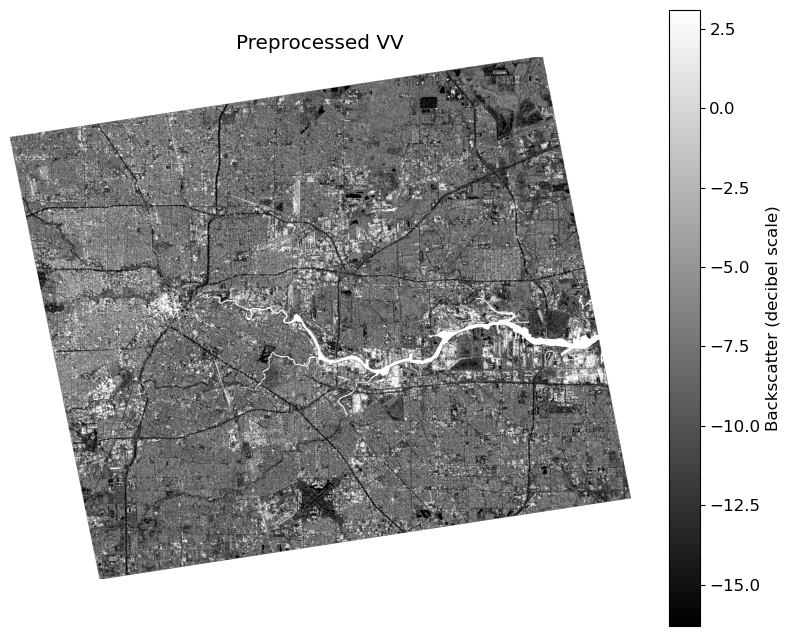

In [11]:

# Plot
plt.figure(figsize=(10, 8))
plt.imshow(vv, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar(label='Backscatter (decibel scale)')
plt.title("Preprocessed VV")
plt.axis('off')
plt.show()

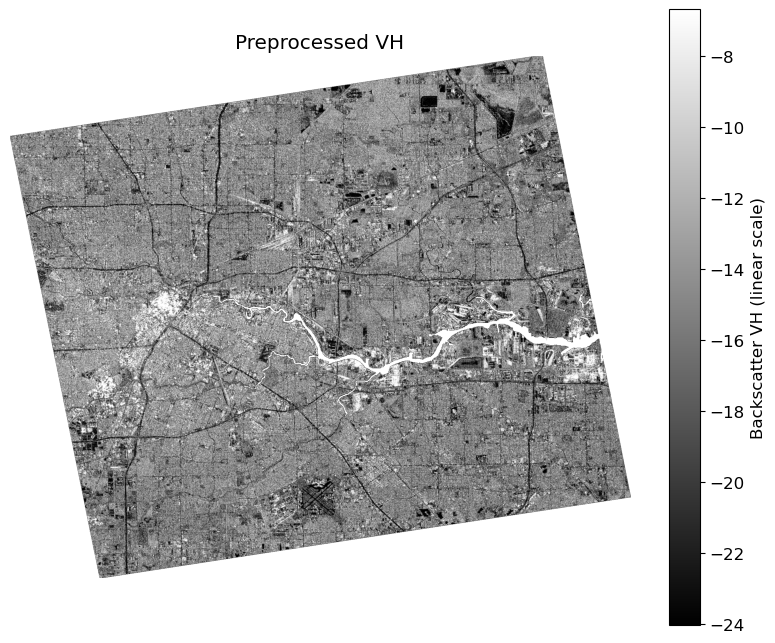

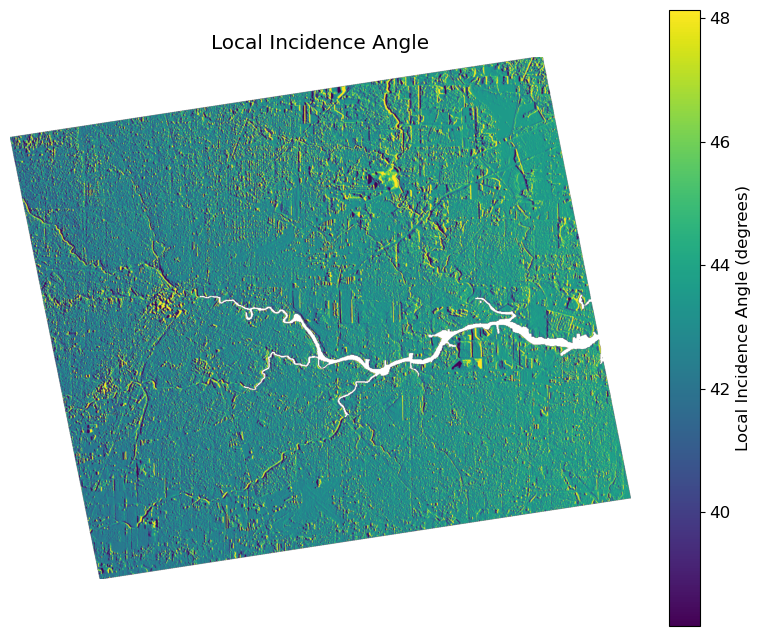

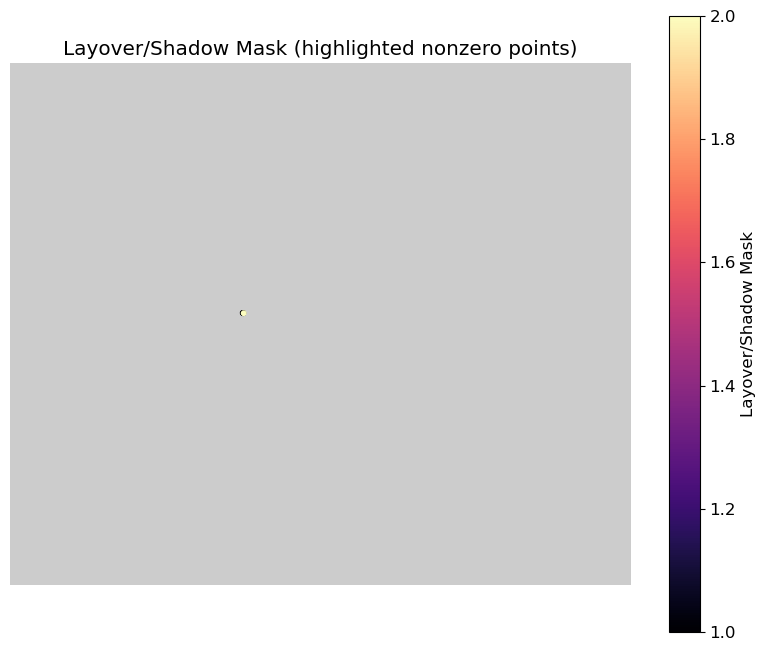

In [12]:
# File paths for VH, local incidence angle, and layover mask
vh_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_VH_gamma0-rtc_db.tif"
inc_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_localIncidenceAngle.tif"
layover_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_layoverShadowMask.tif"

# Helper function to read and mask raster
def read_and_mask(tif_path):
    with rasterio.open(tif_path) as src:
        arr = src.read(1)
        nodata = src.nodata
    arr = np.array(arr, copy=True)
    if nodata is not None:
        arr = np.ma.masked_equal(arr, nodata)
    arr_finite = arr.filled(np.nan)
    vmin = np.nanpercentile(arr_finite, 2)
    vmax = np.nanpercentile(arr_finite, 98)
    return arr, vmin, vmax

# Read and mask VH
vh, vh_vmin, vh_vmax = read_and_mask(vh_file)
# Read and mask local incidence angle
inc, inc_vmin, inc_vmax = read_and_mask(inc_file)
# Read and mask layover mask (binary, so no percentile scaling)
with rasterio.open(layover_file) as src:
    layover = src.read(1)
    nodata = src.nodata
layover = np.array(layover, copy=True)
if nodata is not None:
    layover = np.ma.masked_equal(layover, nodata)

# Plot VH
plt.figure(figsize=(10, 8))
plt.imshow(vh, cmap='gray', vmin=vh_vmin, vmax=vh_vmax)
plt.colorbar(label='Backscatter VH (linear scale)')
plt.title("Preprocessed VH")
plt.axis('off')
plt.show()

# Plot local incidence angle
plt.figure(figsize=(10, 8))
plt.imshow(inc, cmap='viridis', vmin=inc_vmin, vmax=inc_vmax)
plt.colorbar(label='Local Incidence Angle (degrees)')
plt.title("Local Incidence Angle")
plt.axis('off')
plt.show()


# Plot layover mask (show only nonzero/meaningful values)
plt.figure(figsize=(10, 8))
masked_layover = np.ma.masked_less_equal(layover, 0.01)  # mask values <= 0.01

# Find indices where layover is not masked (i.e., nonzero)
y, x = np.where(~masked_layover.mask)

plt.imshow(np.zeros_like(layover), cmap='gray', alpha=0.2)  # faint background
plt.scatter(x, y, c=masked_layover.data[y, x], cmap='magma', s=10, marker='o')
plt.colorbar(label='Layover/Shadow Mask')
plt.title("Layover/Shadow Mask (highlighted nonzero points)")
plt.axis('off')
plt.show()

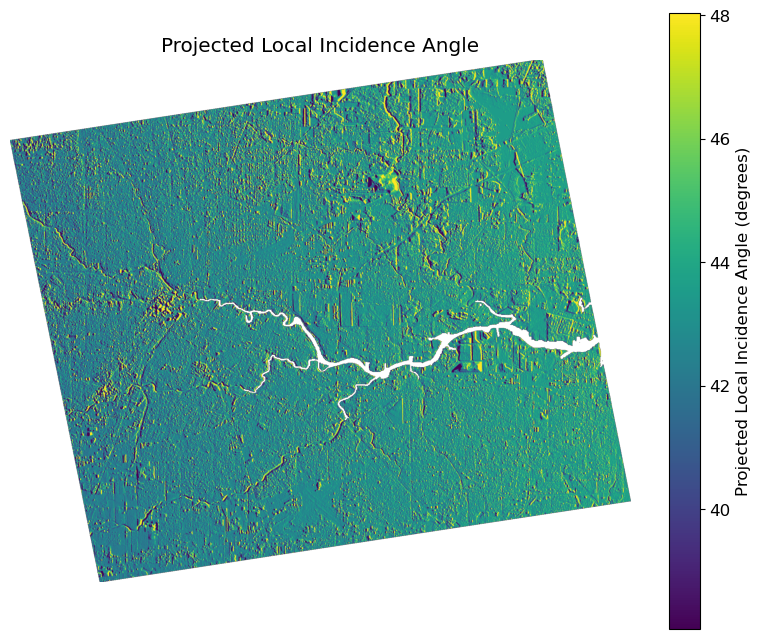

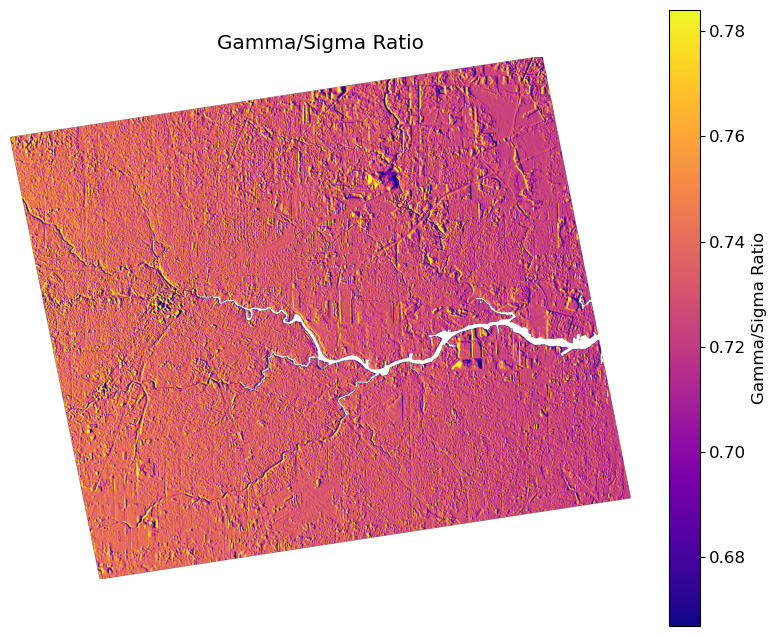

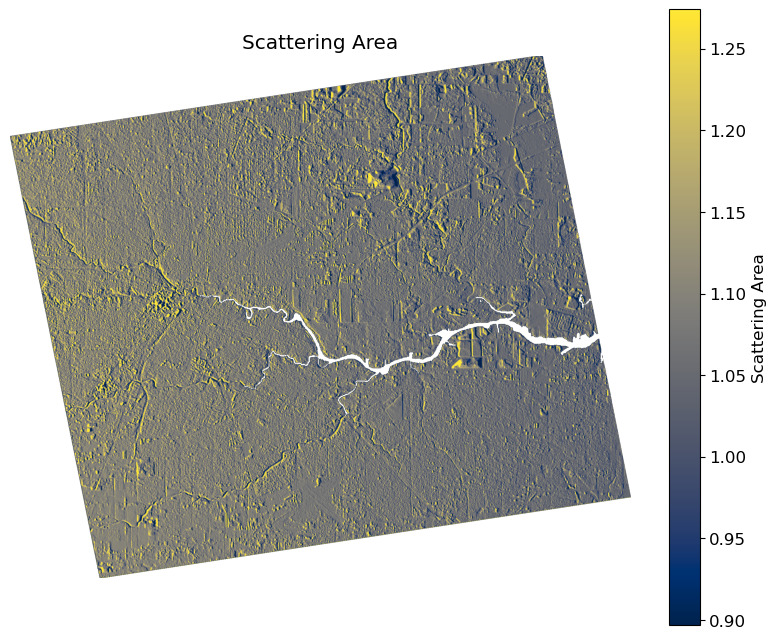

In [13]:
# File paths for additional layers
proj_inc_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_projectedLocalIncidenceAngle.tif"
dem_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_DEM.tif"
gamma_sigma_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_gammaSigmaRatio.tif"
scattering_area_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_scatteringArea.tif"

# Read and mask projected local incidence angle
proj_inc, proj_inc_vmin, proj_inc_vmax = read_and_mask(proj_inc_file)
plt.figure(figsize=(10, 8))
plt.imshow(proj_inc, cmap='viridis', vmin=proj_inc_vmin, vmax=proj_inc_vmax)
plt.colorbar(label='Projected Local Incidence Angle (degrees)')
plt.title("Projected Local Incidence Angle")
plt.axis('off')
plt.show()

# Read and mask DEM
#dem, dem_vmin, dem_vmax = read_and_mask(dem_file)
#plt.figure(figsize=(10, 8))
#plt.imshow(dem, cmap='terrain', vmin=dem_vmin, vmax=dem_vmax)
#plt.colorbar(label='DEM (meters)')
#plt.title("DEM")
#plt.axis('off')
#plt.show()

# Read and mask gamma/sigma ratio
gamma_sigma, gamma_sigma_vmin, gamma_sigma_vmax = read_and_mask(gamma_sigma_file)
plt.figure(figsize=(10, 8))
plt.imshow(gamma_sigma, cmap='plasma', vmin=gamma_sigma_vmin, vmax=gamma_sigma_vmax)
plt.colorbar(label='Gamma/Sigma Ratio')
plt.title("Gamma/Sigma Ratio")
plt.axis('off')
plt.show()

# Read and mask scattering area
scattering_area, scattering_area_vmin, scattering_area_vmax = read_and_mask(scattering_area_file)
plt.figure(figsize=(10, 8))
plt.imshow(scattering_area, cmap='cividis', vmin=scattering_area_vmin, vmax=scattering_area_vmax)
plt.colorbar(label='Scattering Area')
plt.title("Scattering Area")
plt.axis('off')
plt.show()

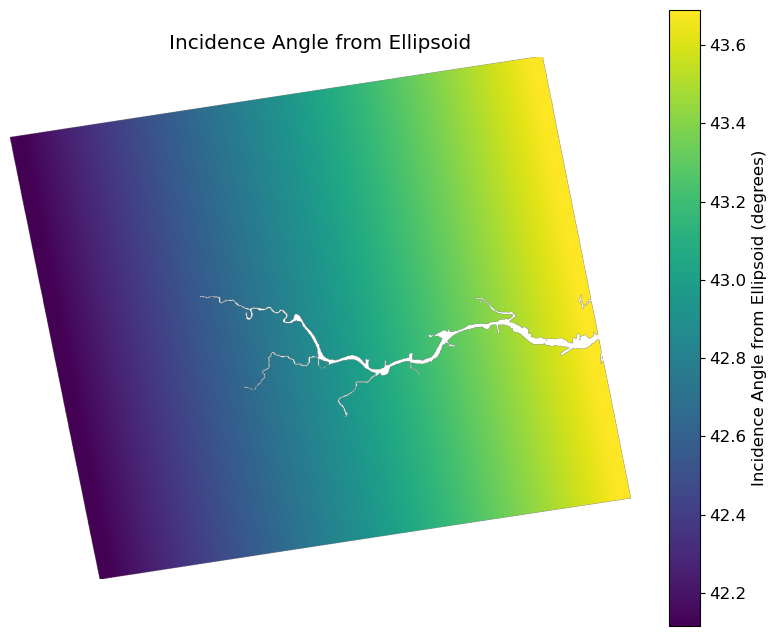

In [14]:
# File path for incidenceAngleFromEllipsoid
ellipsoid_inc_file = "/home/st-juho/code_testing/preprocessed/S1A__IW___A_20240828T002651_incidenceAngleFromEllipsoid.tif"

# Read and mask incidence angle from ellipsoid
ellipsoid_inc, ellipsoid_inc_vmin, ellipsoid_inc_vmax = read_and_mask(ellipsoid_inc_file)

plt.figure(figsize=(10, 8))
plt.imshow(ellipsoid_inc, cmap='viridis', vmin=ellipsoid_inc_vmin, vmax=ellipsoid_inc_vmax)
plt.colorbar(label='Incidence Angle from Ellipsoid (degrees)')
plt.title("Incidence Angle from Ellipsoid")
plt.axis('off')
plt.show()